In [74]:
import json
import numpy as np
import matplotlib.pyplot as plt

In [25]:
summoner_name = "Phoque+éberlué"
summoner_id = 'WQF87iAxVYxyVgB6W1hY4TLuNBGZoNnpKynKHaKI19-S592f'

In [3]:
# Loading the summary file
with open(f'../out/{summoner_name}_summuary.json') as file:
    summary = json.load(file)

In [4]:
summary

{'EUW1_6136998966': {'win': False, 'champion': 'Rammus'},
 'EUW1_6136940073': {'win': True, 'champion': 'Rammus'},
 'EUW1_6136905434': {'win': True, 'champion': 'Rammus'},
 'EUW1_6136879159': {'win': False, 'champion': 'Rammus'},
 'EUW1_6136851586': {'win': False, 'champion': 'Akshan'},
 'EUW1_6136817008': {'win': False, 'champion': 'Rammus'},
 'EUW1_6136214910': {'win': False, 'champion': 'Rammus'},
 'EUW1_6136106763': {'win': False, 'champion': 'Rammus'},
 'EUW1_6136051197': {'win': False, 'champion': 'Rammus'},
 'EUW1_6135708038': {'win': True, 'champion': 'Rammus'},
 'EUW1_6135635897': {'win': False, 'champion': 'Rammus'},
 'EUW1_6135581703': {'win': True, 'champion': 'Rammus'},
 'EUW1_6135534759': {'win': True, 'champion': 'Rammus'},
 'EUW1_6135497604': {'win': False, 'champion': 'Rammus'},
 'EUW1_6135468291': {'win': False, 'champion': 'Rammus'},
 'EUW1_6135430029': {'win': True, 'champion': 'Rammus'},
 'EUW1_6135407108': {'win': True, 'champion': 'Rammus'},
 'EUW1_6135385443': {

In [90]:
deaths = np.zeros(len(summary))
kills = np.zeros(len(summary))
assists = np.zeros(len(summary))
total_pings = np.zeros(len(summary))
goldSpent = np.zeros(len(summary))
wins = np.zeros(len(summary))

In [91]:
i = 0

for game_id, dic in summary.items():
    with open(f'../out/{summoner_name}_{game_id}.json') as file:
        game_data = json.load(file)
    participants_data = game_data['info']['participants']

    for participant_data in participants_data:
        if participant_data['summonerId'] == summoner_id:

            # Ignoring remakes
            if participant_data['gameEndedInEarlySurrender']:
                deaths[i] = np.nan
                kills[i] = np.nan
                assists[i] = np.nan
                total_pings[i] = np.nan
                goldSpent[i] = np.nan
                wins[i] = np.nan
                break

            deaths[i] = participant_data['deaths']
            kills[i] = participant_data['kills']
            assists[i] = participant_data['assists']
            goldSpent[i] = participant_data['goldSpent']
            wins[i] = participant_data['win']

            if 'allInPings' in participant_data:
                total_pings[i] = participant_data['allInPings'] + \
                                 participant_data['assistMePings'] + \
                                 participant_data['baitPings'] + \
                                 participant_data['basicPings'] + \
                                 participant_data['dangerPings'] + \
                                 participant_data['commandPings'] + \
                                 participant_data['dangerPings'] + \
                                 participant_data['enemyMissingPings'] + \
                                 participant_data['enemyVisionPings'] + \
                                 participant_data['getBackPings'] + \
                                 participant_data['holdPings'] + \
                                 participant_data['needVisionPings'] + \
                                 participant_data['onMyWayPings'] + \
                                 participant_data['pushPings'] + \
                                 participant_data['visionClearedPings']
            elif 'basicPings' in participant_data:
                total_pings[i] = participant_data['basicPings']
            else:
                total_pings[i] = np.nan



    i+=1

In [108]:
deaths = deaths[~np.isnan(deaths)]
kills = kills[~np.isnan(kills)]
assists = assists[~np.isnan(assists)]
total_pings = total_pings[~np.isnan(total_pings)]
goldSpent = goldSpent[~np.isnan(goldSpent)]
wins = wins[~np.isnan(wins)]

In [62]:
total_pings

array([14., 29.,  6., 10.,  9., 19., nan, 19., 10., 36., 18., 15., 23.,
       25.,  9., 13., 12., 13., 15., 22.,  2.,  7., 18., 32., 10., 11.,
       24., 22., 17., 16.,  7., 36.,  7.,  6.,  6., 13., 22., 10., 17.,
       16., 10.,  8., 11., 29., 27., 22., 14., 24., 11., 14.,  4., 15.,
       11., 17., 10., 25.,  8., 12., 16., 14., 14.,  7., 24., 19., 20.,
       11., 15., 18., 22., 24., 26.,  7., 18., 11.,  6., 19., 22., 49.,
       30.,  9., 22., 10., 22.,  9., 31., 15., 12., 42., 11., 14., 30.,
       44., 18., 19., 10., 17.,  7., 28.,  5., 11.,  7.,  8., 24., 26.,
        7.,  8., 20., 31., 15., 52., 16.,  8.,  9., 13., 23., 28., 14.,
       22., 17., 25., 32., 23., 20., 44., 14., 16., 56.,  4., 12.,  8.,
       19.,  9., 22., 28., 13., 24., 28.,  2., 24.,  5., 10.,  7., 33.,
       27.,  4., 18.,  5., 19., 12., 12., 20.,  9., 23., 22., 24., 19.,
       nan, 15., 13., 16.,  2.,  8., 12., 12., 26., 25., 40.,  5.,  5.,
       10., 13., 11., 40.,  4., 23., 13., 22.,  4.,  8., 36., 21

# Calcul de vraissemblance sur les parametres

In [101]:
np.mean(deaths)

5.817391304347826

In [102]:
np.cov(deaths)

array(9.82146779)

In [103]:
# Vraissemblance monovarie
def vraissemblanceMonovarie(m, n, variance):
    return - (n - m + 1)/2 * (1 + np.log(2 * np.pi * (variance ** 2)))

In [104]:
# Calcul de la vraissemblance globale
def vraissemblanceGlobale(data, step = 1, window_len = 20):
    nb_valeurs = int((len(data) - window_len) / step)
    vraiss_avant = np.zeros(nb_valeurs)
    vraiss_apres = np.zeros(nb_valeurs)
    t = len(data)

    i = 0
    for m in range(window_len, len(data), step):
        vraiss_avant[i] = vraissemblanceMonovarie(1, m, np.cov(data[0:m]))
        vraiss_apres[i] = vraissemblanceMonovarie(m + 1, t, np.cov(data[m+1:t]))
        i += 1

    vraiss_totale = vraiss_avant + vraiss_apres

    return vraiss_totale

In [109]:
deaths_vraiss_totale = vraissemblanceGlobale(deaths)
kills_vraiss_totale = vraissemblanceGlobale(kills)
assists_vraiss_totale = vraissemblanceGlobale(assists)
total_pings_vraiss_totale = vraissemblanceGlobale(total_pings)
goldSpent_vraiss_totale = vraissemblanceGlobale(goldSpent)

/tmp/ipykernel_7301/1321204729.py:11: RuntimeWarning: Degrees of freedom <= 0 for slice
  vraiss_apres[i] = vraissemblanceMonovarie(m + 1, t, np.cov(data[m+1:t]))
/home/andrewmhdb/Desktop/cours/crypto/lolStreakAnalyser/lib/python3.10/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/andrewmhdb/Desktop/cours/crypto/lolStreakAnalyser/lib/python3.10/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/andrewmhdb/Desktop/cours/crypto/lolStreakAnalyser/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/andrewmhdb/Desktop/cours/crypto/lolStreakAnalyser/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


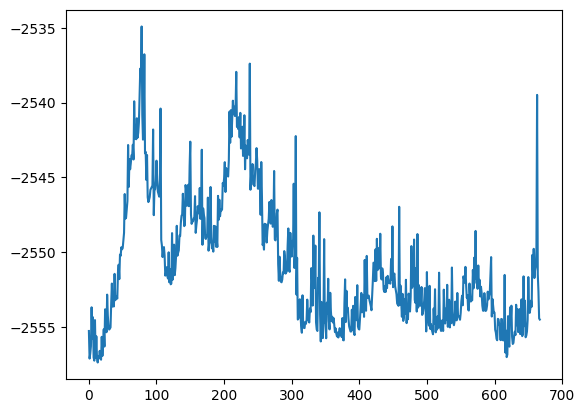

In [114]:
plt.plot(deaths_vraiss_totale)

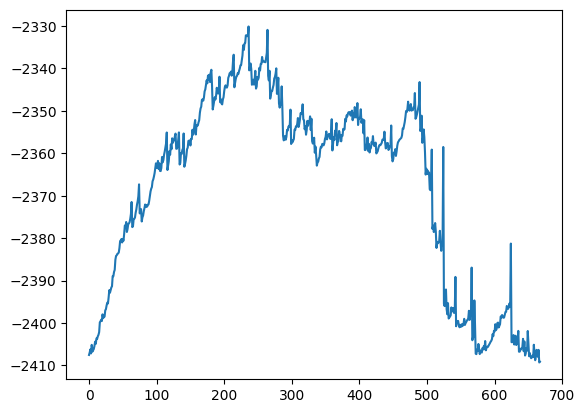

In [111]:
plt.plot(kills_vraiss_totale)

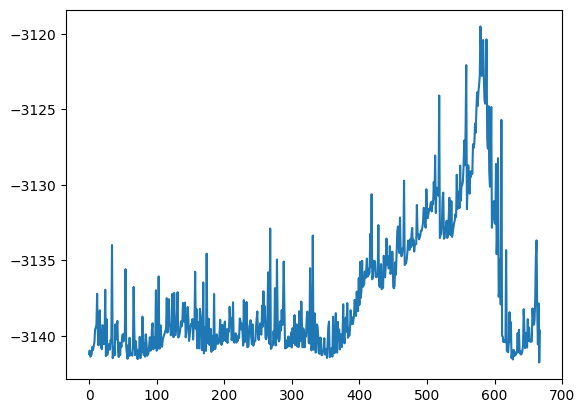

In [112]:
plt.plot(assists_vraiss_totale)

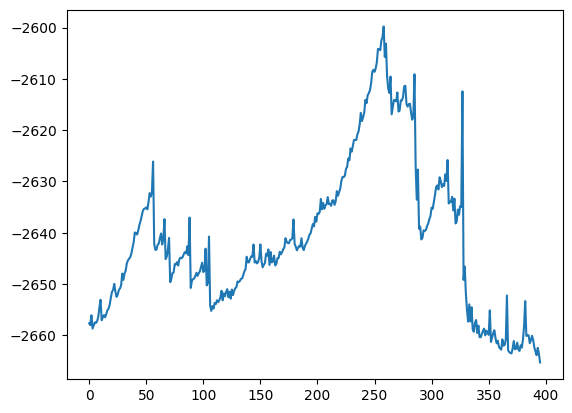

In [113]:
plt.plot(total_pings_vraiss_totale)

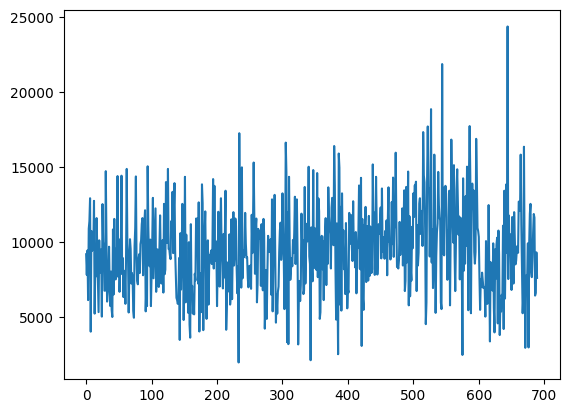

In [115]:
plt.plot(goldSpent)

# Displaying win and loses

In [93]:
print(wins)

[0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1.
 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1.
 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1.
 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1.
 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1.
 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1.
 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0.
 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1.
 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 0.
 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0.
 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1.
 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1.
 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1.
 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0.

In [96]:
win_evolution = np.zeros(len(wins))
win_count = 0
i = 0

for w in wins:
    if w:
       win_count += 1
    else:
        win_count -= 1
    win_evolution[i] = win_count
    i+=1

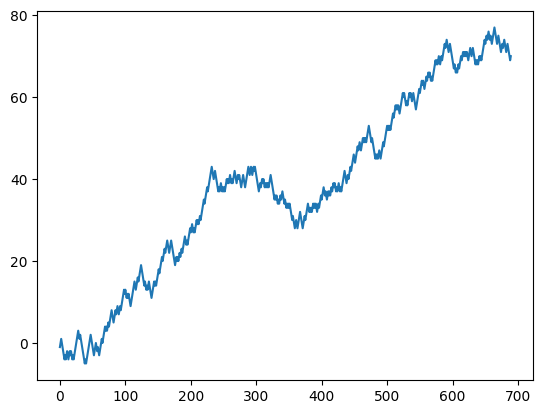

In [97]:
plt.plot(win_evolution)